In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset,random_split
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_recall_fscore_support, roc_curve, auc, precision_score,recall_score, f1_score
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
print(device)

cuda


In [6]:
bicycle_file_path = '/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/bicycle'
motorcycle_file_path = '/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/motorcycle'
bus_file_path = '/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/bus'
car_file_path = '/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/car'
truck_file_path = '/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/single_unit_truck'

In [7]:
import plotly.express as px

class_names = ['bicycle', 'bus','car','motorcycle','truck'] 
bicycle = len(os.listdir(bicycle_file_path))
bus = len(os.listdir(bus_file_path))
car = len(os.listdir(car_file_path))
motorcycle = len(os.listdir(motorcycle_file_path))
truck = len(os.listdir(truck_file_path))

n_images = [bicycle, bus, car,motorcycle,truck]

fig = px.bar(x=class_names, y=n_images, color=class_names, labels={'x': 'Class', 'y': 'Number of Images'}, title='Count of the Images')
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [8]:
from sklearn.utils import resample

# Mapping labels to numerical values
label_mapping = {'bicycle': 0, 'motorcycle': 1, 'bus': 2, 'car': 3, 'truck': 4}

# Function to down-sample a class
def downsample_class(class_path, target_size, label):
    files = os.listdir(class_path)
    downsampled_files = resample(files, replace=False, n_samples=target_size, random_state=42)
    labeled_files = [(os.path.join(class_path, file), label_mapping[label]) for file in downsampled_files]
    return labeled_files

# Determine the minimum number of samples across all classes
min_samples = min(len(os.listdir(bicycle_file_path)), len(os.listdir(motorcycle_file_path)), len(os.listdir(bus_file_path)), len(os.listdir(car_file_path)), len(os.listdir(truck_file_path)))

# Store down-sampled files and labels in data[] list
data = []

# Down-sample each class and append labeled data to the data[] list
data.extend(downsample_class(bicycle_file_path, min_samples, 'bicycle'))
data.extend(downsample_class(motorcycle_file_path, min_samples, 'motorcycle'))
data.extend(downsample_class(bus_file_path, min_samples, 'bus'))
data.extend(downsample_class(car_file_path, min_samples, 'car'))
data.extend(downsample_class(truck_file_path, min_samples, 'truck'))

# Display the first few entries in data[]
print(data[:5])

[('/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/bicycle/00275397.jpg', 0), ('/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/bicycle/00166176.jpg', 0), ('/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/bicycle/00369905.jpg', 0), ('/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/bicycle/00210695.jpg', 0), ('/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/bicycle/00399755.jpg', 0)]


In [7]:
len(data)

9910

In [8]:
random.shuffle(data)

In [9]:
data[0]

('/kaggle/input/miotcd-dataset-50000-imagesclassification/train1/bicycle/00275397.jpg',
 0)

In [11]:
count = {0:0,1:0,2:0,3:0,4:0}
for d in data:
    count[d[1]]+=1

In [12]:
class_names = ['bicycle','motorcycle','bus','car','truck'] 
fig = px.bar(x=class_names, y=count, color=class_names, labels={'x': 'Class', 'y': 'Number of Images'}, title='Count of the Images')
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [13]:
from PIL import Image
import numpy as np

# Function to resize and normalize images
def preprocess_images(data, target_size=(224, 224), normalization=True):
    processed_data = []
    
    for file_path, label in data:
        # Open the image file
        image = Image.open(file_path)
        
        # Resize the image
        image = image.resize(target_size)
        
        # Convert the image to a numpy array
        image_array = np.array(image)
        
        # Normalize the image (if normalization is enabled)
        if normalization:
            image_array = image_array / 255.0  # Normalize pixel values to the range [0, 1]
        
        # Append the processed data as a tuple (image_array, label)
        processed_data.append((image_array, label))
    
    return processed_data

df = preprocess_images(data, target_size=(224, 224), normalization=True)

In [16]:
train_data,test_data  = train_test_split(df, train_size=0.8, random_state=42)

In [17]:
test_data,valid_data = train_test_split(test_data, test_size=0.5, random_state=42)

In [18]:
len(test_data)

991

In [19]:
# Assuming you have the processed data in resized_normalized_data
# where each element is a tuple (image_array, label)
# Custom dataset class
class CustomDataset:
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        image_array, label = self.data[index]
        # Convert image_array to PyTorch tensor
        image_tensor = torch.tensor(image_array, dtype=torch.float32).permute(2, 0, 1)
        return image_tensor, torch.tensor(label, dtype=torch.long)
# Create DataLoader for training and testing sets
batch_size = 64
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)
validation_dataset = CustomDataset(valid_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [62]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

In [63]:
# Instantiate the model
model = SimpleCNN().to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [64]:
num_epochs = 10
loss_graph = []
loss_valid = []
accuracy_graph = []
accuracy_valid = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    # Print training loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    accuracy_train = correct_train / total_train * 100
    loss_graph.append(epoch_loss)
    accuracy_graph.append(accuracy_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy_train:.2f}%')
    # Validation loop
    model.eval()
    correct_val = 0
    total_val = 0
    test_loss = 0
    valid_loss = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    accuracy_val = correct_val / total_val * 100
    valid_loss = valid_loss / len(validation_loader)
    accuracy_valid.append(accuracy_val)
    loss_valid.append(valid_loss)
    print(f'validation Accuracy: {accuracy_val:.2f}% , validation loss : {valid_loss:.4f}')

Epoch 1/10, Loss: 1.3568, Accuracy: 44.70%
validation Accuracy: 63.07% , validation loss : 1.0045
Epoch 2/10, Loss: 0.8958, Accuracy: 65.14%
validation Accuracy: 68.62% , validation loss : 0.7917
Epoch 3/10, Loss: 0.7155, Accuracy: 72.94%
validation Accuracy: 74.37% , validation loss : 0.6509
Epoch 4/10, Loss: 0.6166, Accuracy: 76.94%
validation Accuracy: 78.10% , validation loss : 0.5826
Epoch 5/10, Loss: 0.5490, Accuracy: 79.84%
validation Accuracy: 80.32% , validation loss : 0.5512
Epoch 6/10, Loss: 0.4996, Accuracy: 81.98%
validation Accuracy: 81.03% , validation loss : 0.5153
Epoch 7/10, Loss: 0.4415, Accuracy: 84.37%
validation Accuracy: 83.55% , validation loss : 0.4767
Epoch 8/10, Loss: 0.4084, Accuracy: 85.38%
validation Accuracy: 82.95% , validation loss : 0.4805
Epoch 9/10, Loss: 0.3754, Accuracy: 86.69%
validation Accuracy: 84.66% , validation loss : 0.4264
Epoch 10/10, Loss: 0.3445, Accuracy: 87.84%
validation Accuracy: 83.85% , validation loss : 0.4393


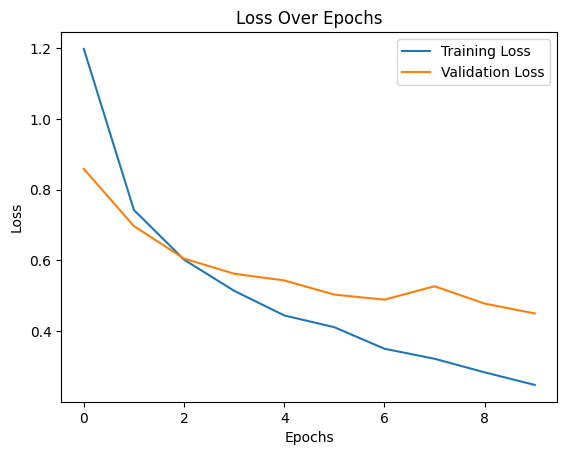

In [20]:
plt.plot(loss_graph, label='Training Loss')
plt.plot(loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

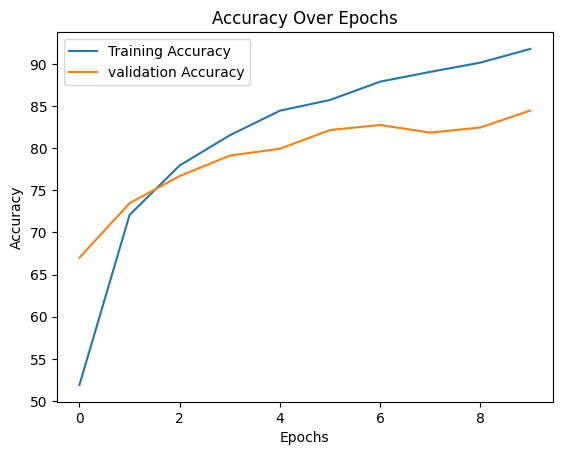

In [21]:
plt.plot(accuracy_graph, label='Training Accuracy')
plt.plot(accuracy_valid, label='validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

In [22]:
# Final evaluation on the test set
model.eval()
correct_top1_test = 0
correct_top3_test = 0
total_test = 0
all_labels = []
all_predictions_top = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        # Top-1 accuracy
        _, predicted_top1 = torch.max(outputs.data, 1)
        correct_top1_test += (predicted_top1 == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions_top.extend(predicted_top1.cpu().numpy())

        # Top-3 accuracy
        _, predicted_top3 = torch.topk(outputs.data, 3, dim=1)
        correct_top3_test += torch.sum(predicted_top3 == labels.view(-1, 1)).item()

        total_test += labels.size(0)

# Calculate top-1 and top-3 accuracy for the test set
top1_accuracy_test = correct_top1_test / total_test * 100
top3_accuracy_test = correct_top3_test / total_test * 100

print(f'Final Test Top-1 Accuracy: {top1_accuracy_test:.2f}%')
print(f'Final Test Top-3 Accuracy: {top3_accuracy_test:.2f}%')

conf_matrix_top1 = confusion_matrix(all_labels, all_predictions_top)
sns.heatmap(conf_matrix_top1, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")

Final Test Accuracy: 84.26%


In [22]:
train_data,test_data  = train_test_split(df, train_size=0.8, random_state=42)

In [23]:
test_data,validation_data = train_test_split(test_data, test_size=0.5, random_state=42)

In [24]:
class CustomDataset:
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        image_array, label = self.data[index]
        # Convert image_array to PyTorch tensor
        image_tensor = torch.tensor(image_array, dtype=torch.float32).permute(2, 0, 1)
        return image_tensor, torch.tensor(label, dtype=torch.long)
# Create DataLoader for training and testing sets
batch_size = 128
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)
validation_dataset = CustomDataset(validation_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [40]:
class SimpleCNN1(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 14 * 14, 256)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(256,512)
        self.relu6 = nn.ReLU()
        self.fc3 = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu5(self.fc1(x))
        x = self.relu6(self.fc2(x))
        x = self.fc3(x)
        return x

In [41]:
# Instantiate the model1
model1 = SimpleCNN1().to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [43]:
num_epochs = 15
loss_graph = []
loss_valid = []
accuracy_graph = []
accuracy_valid = []
for epoch in range(num_epochs):
    model1.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    # Print training loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    accuracy_train = correct_train / total_train * 100
    loss_graph.append(epoch_loss)
    accuracy_graph.append(accuracy_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy_train:.2f}%')
    # Validation loop
    model1.eval()
    correct_val = 0
    total_val = 0
    test_loss = 0
    valid_loss = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)            
            outputs = model1(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    accuracy_val = correct_val / total_val * 100
    valid_loss = valid_loss / len(validation_loader)
    accuracy_valid.append(accuracy_val)
    loss_valid.append(valid_loss)
    print(f'validation Accuracy: {accuracy_val:.2f}% , validation loss : {valid_loss:.4f}')

Epoch 1/15, Loss: 0.5147, Accuracy: 80.71%
validation Accuracy: 83.96% , validation loss : 0.4560
Epoch 2/15, Loss: 0.3650, Accuracy: 86.83%
validation Accuracy: 86.68% , validation loss : 0.3534
Epoch 3/15, Loss: 0.2597, Accuracy: 90.78%
validation Accuracy: 89.40% , validation loss : 0.3028
Epoch 4/15, Loss: 0.1739, Accuracy: 93.83%
validation Accuracy: 90.01% , validation loss : 0.2915
Epoch 5/15, Loss: 0.1098, Accuracy: 96.28%
validation Accuracy: 91.02% , validation loss : 0.2872
Epoch 6/15, Loss: 0.0622, Accuracy: 97.84%
validation Accuracy: 90.21% , validation loss : 0.3309
Epoch 7/15, Loss: 0.0499, Accuracy: 98.41%
validation Accuracy: 91.02% , validation loss : 0.3559
Epoch 8/15, Loss: 0.0392, Accuracy: 98.66%
validation Accuracy: 91.73% , validation loss : 0.3030
Epoch 9/15, Loss: 0.0228, Accuracy: 99.36%
validation Accuracy: 88.60% , validation loss : 0.5343
Epoch 10/15, Loss: 0.0448, Accuracy: 98.36%
validation Accuracy: 90.01% , validation loss : 0.4405
Epoch 11/15, Loss: 

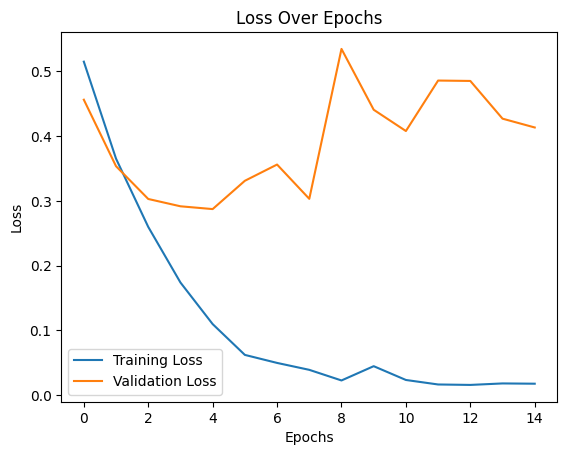

In [44]:
plt.plot(loss_graph, label='Training Loss')
plt.plot(loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

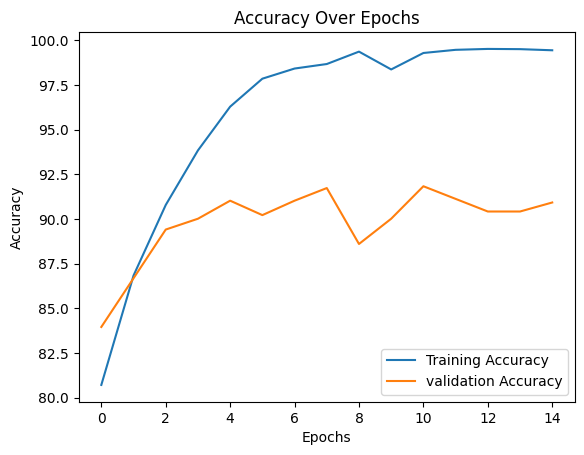

In [45]:
plt.plot(accuracy_graph, label='Training Accuracy')
plt.plot(accuracy_valid, label='validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

Final Test Top-1 Accuracy: 90.31%
Final Test Top-3 Accuracy: 99.29%


Text(0.5, 1.0, 'Confusion Matrix')

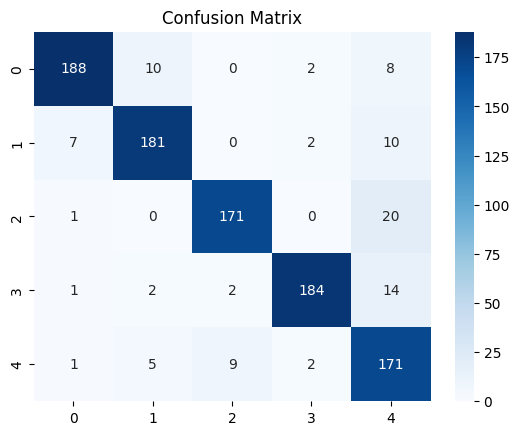

In [46]:
# Final evaluation on the test set
model1.eval()
correct_top1_test = 0
correct_top3_test = 0
total_test = 0
all_labels = []
all_predictions_top = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model1(inputs)

        # Top-1 accuracy
        _, predicted_top1 = torch.max(outputs.data, 1)
        correct_top1_test += (predicted_top1 == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions_top.extend(predicted_top1.cpu().numpy())

        # Top-3 accuracy
        _, predicted_top3 = torch.topk(outputs.data, 3, dim=1)
        correct_top3_test += torch.sum(predicted_top3 == labels.view(-1, 1)).item()

        total_test += labels.size(0)

# Calculate top-1 and top-3 accuracy for the test set
top1_accuracy_test = correct_top1_test / total_test * 100
top3_accuracy_test = correct_top3_test / total_test * 100

print(f'Final Test Top-1 Accuracy: {top1_accuracy_test:.2f}%')
print(f'Final Test Top-3 Accuracy: {top3_accuracy_test:.2f}%')

conf_matrix_top1 = confusion_matrix(all_labels, all_predictions_top)
sns.heatmap(conf_matrix_top1, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")

In [47]:
model2 = SimpleCNN1().to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.0001,weight_decay=0.01)

In [48]:
num_epochs = 15
loss_graph = []
loss_valid = []
accuracy_graph = []
accuracy_valid = []
for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    # Print training loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    accuracy_train = correct_train / total_train * 100
    loss_graph.append(epoch_loss)
    accuracy_graph.append(accuracy_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy_train:.2f}%')
    # Validation loop
    model2.eval()
    correct_val = 0
    total_val = 0
    test_loss = 0
    valid_loss = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)            
            outputs = model2(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    accuracy_val = correct_val / total_val * 100
    valid_loss = valid_loss / len(validation_loader)
    accuracy_valid.append(accuracy_val)
    loss_valid.append(valid_loss)
    print(f'validation Accuracy: {accuracy_val:.2f}% , validation loss : {valid_loss:.4f}')

Epoch 1/15, Loss: 1.6056, Accuracy: 25.08%
validation Accuracy: 28.15% , validation loss : 1.5903
Epoch 2/15, Loss: 1.4035, Accuracy: 42.05%
validation Accuracy: 48.74% , validation loss : 1.1071
Epoch 3/15, Loss: 0.9423, Accuracy: 62.46%
validation Accuracy: 68.72% , validation loss : 0.8059
Epoch 4/15, Loss: 0.7961, Accuracy: 69.05%
validation Accuracy: 72.65% , validation loss : 0.7140
Epoch 5/15, Loss: 0.7099, Accuracy: 73.20%
validation Accuracy: 73.86% , validation loss : 0.6691
Epoch 6/15, Loss: 0.6647, Accuracy: 75.01%
validation Accuracy: 76.29% , validation loss : 0.6448
Epoch 7/15, Loss: 0.6138, Accuracy: 76.96%
validation Accuracy: 79.01% , validation loss : 0.5748
Epoch 8/15, Loss: 0.5854, Accuracy: 78.15%
validation Accuracy: 78.41% , validation loss : 0.5855
Epoch 9/15, Loss: 0.5314, Accuracy: 80.64%
validation Accuracy: 80.63% , validation loss : 0.5388
Epoch 10/15, Loss: 0.5169, Accuracy: 80.79%
validation Accuracy: 82.34% , validation loss : 0.5031
Epoch 11/15, Loss: 

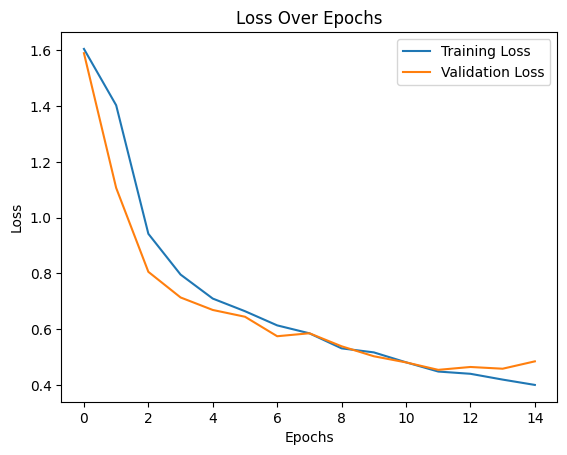

In [49]:
plt.plot(loss_graph, label='Training Loss')
plt.plot(loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

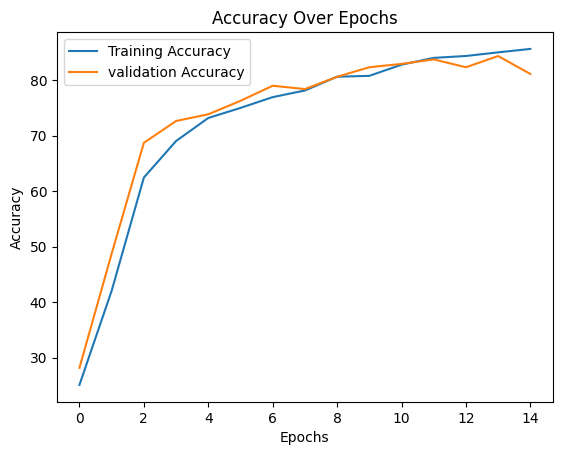

In [50]:
plt.plot(accuracy_graph, label='Training Accuracy')
plt.plot(accuracy_valid, label='validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

Final Test Top-1 Accuracy: 81.53%
Final Test Top-3 Accuracy: 97.48%


Text(0.5, 1.0, 'Confusion Matrix')

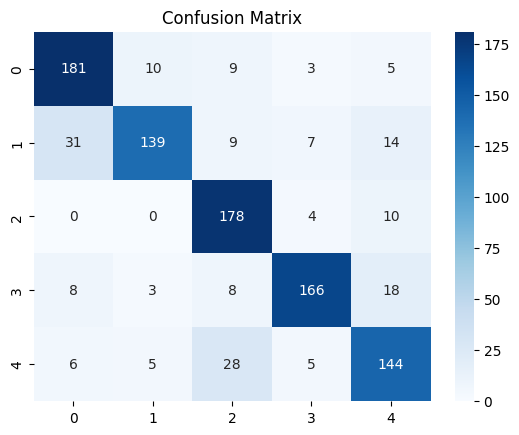

In [51]:
# Final evaluation on the test set
model2.eval()
correct_top1_test = 0
correct_top3_test = 0
total_test = 0
all_labels = []
all_predictions_top = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model2(inputs)

        # Top-1 accuracy
        _, predicted_top1 = torch.max(outputs.data, 1)
        correct_top1_test += (predicted_top1 == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions_top.extend(predicted_top1.cpu().numpy())

        # Top-3 accuracy
        _, predicted_top3 = torch.topk(outputs.data, 3, dim=1)
        correct_top3_test += torch.sum(predicted_top3 == labels.view(-1, 1)).item()

        total_test += labels.size(0)

# Calculate top-1 and top-3 accuracy for the test set
top1_accuracy_test = correct_top1_test / total_test * 100
top3_accuracy_test = correct_top3_test / total_test * 100

print(f'Final Test Top-1 Accuracy: {top1_accuracy_test:.2f}%')
print(f'Final Test Top-3 Accuracy: {top3_accuracy_test:.2f}%')

conf_matrix_top1 = confusion_matrix(all_labels, all_predictions_top)
sns.heatmap(conf_matrix_top1, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")

In [78]:
class SimpleCNN2(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 14 * 14, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.relu5 = nn.ReLU()
        
        self.fc2 = nn.Linear(256, 512)
        self.bn6 = nn.BatchNorm1d(512)
        self.relu6 = nn.ReLU()
        
        self.fc3 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        x = self.flatten(x)
        x = self.relu5(self.bn5(self.fc1(x)))
        x = self.relu6(self.bn6(self.fc2(x)))
        x = self.fc3(x)
        return x

In [79]:
model3 = SimpleCNN2().to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.0001)

In [80]:
num_epochs = 15
loss_graph = []
loss_valid = []
accuracy_graph = []
accuracy_valid = []
for epoch in range(num_epochs):
    model3.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    # Print training loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    accuracy_train = correct_train / total_train * 100
    loss_graph.append(epoch_loss)
    accuracy_graph.append(accuracy_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy_train:.2f}%')
    # Validation loop
    model3.eval()
    correct_val = 0
    total_val = 0
    test_loss = 0
    valid_loss = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)            
            outputs = model3(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    accuracy_val = correct_val / total_val * 100
    valid_loss = valid_loss / len(validation_loader)
    accuracy_valid.append(accuracy_val)
    loss_valid.append(valid_loss)
    print(f'validation Accuracy: {accuracy_val:.2f}% , validation loss : {valid_loss:.4f}')

Epoch 1/15, Loss: 0.7174, Accuracy: 75.17%
validation Accuracy: 26.61% , validation loss : 1.6978
Epoch 2/15, Loss: 0.3099, Accuracy: 91.88%
validation Accuracy: 81.02% , validation loss : 0.5417
Epoch 3/15, Loss: 0.1578, Accuracy: 97.65%
validation Accuracy: 89.41% , validation loss : 0.3631
Epoch 4/15, Loss: 0.0774, Accuracy: 99.37%
validation Accuracy: 89.72% , validation loss : 0.3055
Epoch 5/15, Loss: 0.0392, Accuracy: 99.91%
validation Accuracy: 90.98% , validation loss : 0.2726
Epoch 6/15, Loss: 0.0223, Accuracy: 99.98%
validation Accuracy: 90.42% , validation loss : 0.2637
Epoch 7/15, Loss: 0.0144, Accuracy: 100.00%
validation Accuracy: 90.98% , validation loss : 0.2654
Epoch 8/15, Loss: 0.0103, Accuracy: 100.00%
validation Accuracy: 90.48% , validation loss : 0.2678
Epoch 9/15, Loss: 0.0079, Accuracy: 100.00%
validation Accuracy: 90.86% , validation loss : 0.2668
Epoch 10/15, Loss: 0.0065, Accuracy: 100.00%
validation Accuracy: 91.05% , validation loss : 0.2653
Epoch 11/15, Lo

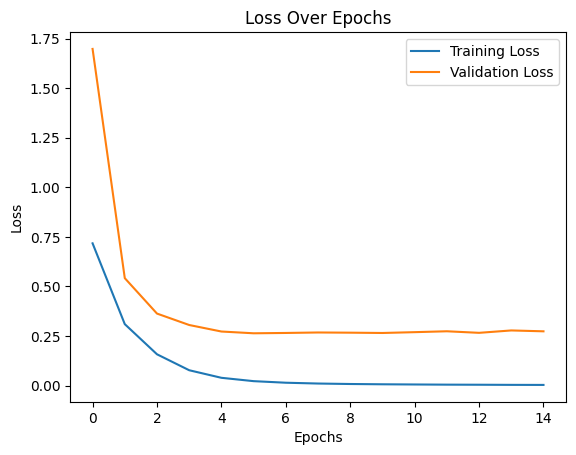

In [81]:
plt.plot(loss_graph, label='Training Loss')
plt.plot(loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

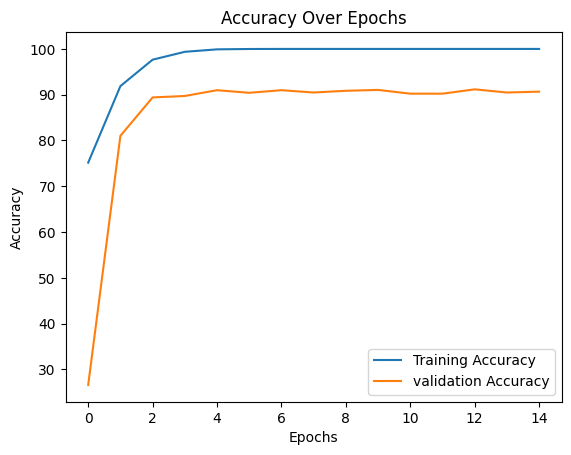

In [82]:
plt.plot(accuracy_graph, label='Training Accuracy')
plt.plot(accuracy_valid, label='validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

Final Test Top-1 Accuracy: 92.03%
Final Test Top-3 Accuracy: 99.19%


Text(0.5, 1.0, 'Confusion Matrix')

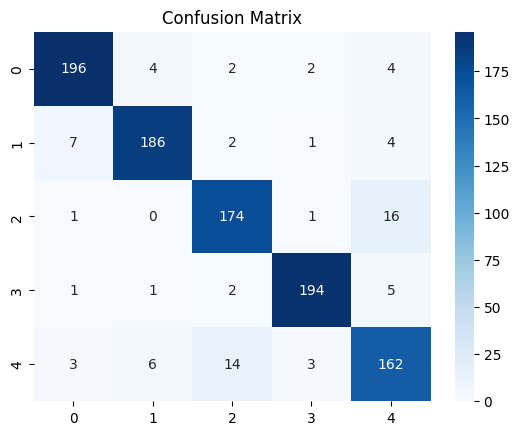

In [83]:
# Final evaluation on the test set
model3.eval()
correct_top1_test = 0
correct_top3_test = 0
total_test = 0
all_labels = []
all_predictions_top = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model3(inputs)

        # Top-1 accuracy
        _, predicted_top1 = torch.max(outputs.data, 1)
        correct_top1_test += (predicted_top1 == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions_top.extend(predicted_top1.cpu().numpy())

        # Top-3 accuracy
        _, predicted_top3 = torch.topk(outputs.data, 3, dim=1)
        correct_top3_test += torch.sum(predicted_top3 == labels.view(-1, 1)).item()

        total_test += labels.size(0)

# Calculate top-1 and top-3 accuracy for the test set
top1_accuracy_test = correct_top1_test / total_test * 100
top3_accuracy_test = correct_top3_test / total_test * 100

print(f'Final Test Top-1 Accuracy: {top1_accuracy_test:.2f}%')
print(f'Final Test Top-3 Accuracy: {top3_accuracy_test:.2f}%')

conf_matrix_top1 = confusion_matrix(all_labels, all_predictions_top)
sns.heatmap(conf_matrix_top1, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")